In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
!git clone https://github.com/time-series-foundation-models/lag-llama/


Cloning into 'lag-llama'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 315 (delta 110), reused 105 (delta 84), pack-reused 162
Receiving objects: 100% (315/315), 227.69 KiB | 7.59 MiB/s, done.
Resolving deltas: 100% (151/151), done.


In [3]:
cd lag-llama

/content/lag-llama


In [4]:
!pip3 install -r requirements.txt --quiet
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir lag-llama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.1/300.1 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 64.0 MB/s eta 0:00:00
ERROR: pip's dependency reso

In [5]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.common import ListDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import seaborn as sns

from sklearn.metrics import mean_absolute_error

<ipython-input-5-778ed56a89a8>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [6]:
# Read data
# ==============================================================================
data_dir = '/content/drive/MyDrive/Python Scripts/Lag Llama experiments/Data'
# data_dir = '../Data/spain/one year'

df = pd.read_csv(data_dir + '/spain_clean.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('60min')
# df['item_id'] = 'waves'
df.drop(columns = ['period'], inplace = True)
df.head()

# Train-val-test split
# ==============================================================================
# one_month = (-1)*30*24 # One month
two_months = (-1)*60*24 # Two months

end_train = two_months + two_months
end_val = two_months

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()
# df_test = df.iloc[end_train:]

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2020-06-18 00:00:00 --- 2024-02-19 23:00:00  (n=32208)
Validation dates : 2024-02-20 00:00:00 --- 2024-04-19 23:00:00  (n=1440)
Test dates       : 2024-04-20 00:00:00 --- 2024-06-18 23:00:00  (n=1440)


In [8]:
def create_gluonts_dataset(df, freq, target_column):
    series = {
        "start": df.index[0],  # start date of the time series
        "target": df[target_column].values,  # target values
    }

    dataset = ListDataset([series], freq=freq)
    return dataset

# Create the GluonTS dataset
train = create_gluonts_dataset(df_train, freq='1H', target_column='wave_height')
test = create_gluonts_dataset(df_test, freq='1H', target_column='wave_height')
val = create_gluonts_dataset(df_val, freq='1H', target_column='wave_height')


print('Train dataset:', train)
print('Validation dataset:',val)
print('Test dataset:',test)

Train dataset: [{'start': Period('2020-06-18 00:00', 'H'), 'target': array([0.78, 0.76, 0.74, ..., 1.11, 1.13, 1.16], dtype=float32)}]
Validation dataset: [{'start': Period('2024-02-20 00:00', 'H'), 'target': array([1.2 , 1.23, 1.26, ..., 1.39, 1.33, 1.26], dtype=float32)}]
Test dataset: [{'start': Period('2024-04-20 00:00', 'H'), 'target': array([1.2 , 1.15, 1.11, ..., 0.86, 0.84, 0.82], dtype=float32)}]


We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [ ]:
# def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cpu", batch_size=1, nonnegative_pred_samples=True):
#     ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=torch.device(device))
#     estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

#     estimator = LagLlamaEstimator(
#         # ckpt_path="lag-llama.ckpt",
#         ckpt_path = 'lag-llama/lag-llama.ckpt',
#         prediction_length=prediction_length,
#         context_length=context_length,
#         device = device,

#         # estimator args
#         input_size=estimator_args["input_size"],
#         n_layer=estimator_args["n_layer"],
#         n_embd_per_head=estimator_args["n_embd_per_head"],
#         n_head=estimator_args["n_head"],
#         scaling=estimator_args["scaling"],
#         time_feat=estimator_args["time_feat"],

#         nonnegative_pred_samples=nonnegative_pred_samples,

#         # linear positional encoding scaling
#         rope_scaling={
#             "type": "linear",
#             "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
#         },

#         batch_size=batch_size,
#         num_parallel_samples=num_samples,
#     )

#     lightning_module = estimator.create_lightning_module().to(device)
#     transformation = estimator.create_transformation()
#     predictor = estimator.create_predictor(transformation, lightning_module)

#     forecast_it, ts_it = make_evaluation_predictions(
#         dataset=dataset,
#         predictor=predictor,
#         num_samples=num_samples
#     )
#     forecasts = list(tqdm(forecast_it, total=len(dataset[0]['target']), desc="Forecasting batches"))
#     tss = list(tqdm(ts_it, total=len(dataset[0]['target']), desc="Ground truth"))

#     return forecasts, tss

## Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [18]:
# Forecast parameters
prediction_length = 24
context_length = 32
num_samples = 50
device = torch.device('cuda')

In [ ]:
# Model definition
ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        device = device,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=1,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [ ]:
# Train
predictor = estimator.train(training_data = train, validation_data = val, cache_data=True, shuffle_buffer_length=1000)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'val_loss' reached 2.89044 (best 2.89044), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'val_loss' reached 2.89044 (best 2.89044), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 100: 'val_loss' reached 2.39750 (best 2.39750), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'val_loss' reached 2.39750 (best 2.39750), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 150: 'val_loss' reached 0.10922 (best 0.10922), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'val_loss' reached 0.10922 (best 0.10922), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 200: 'val_loss' reached -0.03272 (best -0.03272), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 200: 'val_loss' reached -0.03272 (best -0.03272), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 250: 'val_loss' reached -0.07316 (best -0.07316), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 250: 'val_loss' reached -0.07316 (best -0.07316), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 300: 'val_loss' reached -0.69305 (best -0.69305), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=5-step=300.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 300: 'val_loss' reached -0.69305 (best -0.69305), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 350: 'val_loss' reached -1.09120 (best -1.09120), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=6-step=350.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 350: 'val_loss' reached -1.09120 (best -1.09120), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 400: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 450: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 500: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 550: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 600: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 650: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 700: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 750: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 800: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 850: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 900: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 950: 'val_loss' reached -1.16880 (best -1.16880), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=18-step=950.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 950: 'val_loss' reached -1.16880 (best -1.16880), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=18-step=950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 1000: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 1050: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 1100: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 1150: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 1200: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 24, global step 1250: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 25, global step 1300: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 26, global step 1350: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 27, global step 1400: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 28, global step 1450: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 29, global step 1500: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 29, global step 1500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 30, global step 1550: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 30, global step 1550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 31, global step 1600: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 31, global step 1600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 32, global step 1650: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 32, global step 1650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 33, global step 1700: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 33, global step 1700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 34, global step 1750: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 34, global step 1750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 35, global step 1800: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 35, global step 1800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 36, global step 1850: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 36, global step 1850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 37, global step 1900: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 37, global step 1900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 38, global step 1950: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 38, global step 1950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 39, global step 2000: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 39, global step 2000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 40, global step 2050: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 40, global step 2050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 41, global step 2100: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 41, global step 2100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 42, global step 2150: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 42, global step 2150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 43, global step 2200: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 43, global step 2200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 44, global step 2250: 'val_loss' reached -1.35546 (best -1.35546), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=44-step=2250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 44, global step 2250: 'val_loss' reached -1.35546 (best -1.35546), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=44-step=2250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 45, global step 2300: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 45, global step 2300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 46, global step 2350: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 46, global step 2350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 47, global step 2400: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 47, global step 2400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 48, global step 2450: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 48, global step 2450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 49, global step 2500: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 49, global step 2500: 'val_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
context_lengths = [16, 32, 64]
learning_rates = [1e-3, 5e-4, 1e-4]

results = []

for context_length in context_lengths:
    for lr in learning_rates:
        # Model definition
        ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=device)
        estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

        estimator = LagLlamaEstimator(
                ckpt_path="lag-llama/lag-llama.ckpt",
                prediction_length=prediction_length,
                context_length=context_length,
                device = device,

                # distr_output="neg_bin",
                # scaling="mean",
                nonnegative_pred_samples=True,
                aug_prob=0,
                lr=lr,

                # estimator args
                input_size=estimator_args["input_size"],
                n_layer=estimator_args["n_layer"],
                n_embd_per_head=estimator_args["n_embd_per_head"],
                n_head=estimator_args["n_head"],
                time_feat=estimator_args["time_feat"],

                rope_scaling={
                    "type": "linear",
                    "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
                },

                batch_size=1,
                num_parallel_samples=num_samples,
                trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
            )

        # Train
        predictor = estimator.train(training_data = train, validation_data = val, cache_data=True, shuffle_buffer_length=1000)

        # Evaluate the model
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=test,
            predictor=predictor,
            num_samples=num_samples
        )
        forecasts = list(forecast_it)
        tss = list(ts_it)
        evaluator = Evaluator()
        agg_metrics, _ = evaluator(iter(tss), iter(forecasts), num_series=len(test))

        # Store results
        results.append({
            'context_length': context_length,
            'lr': lr,
            'MAE': agg_metrics['mean_wQuantileLoss']
        })

# Print or analyze the results to find the best hyperparameters
print(results)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test,
        predictor=predictor,
        num_samples=num_samples
    )

forecasts = list(tqdm(forecast_it, total=len(df_test), desc="Forecasting batches"))
tss = list(tqdm(ts_it, total=len(df_test), desc="Ground truth"))

Forecasting batches:   0%|          | 0/1440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1440 [00:00<?, ?it/s]

# !!Need to adjust 👇!!


In [ ]:
# Recursive multi-step forecasting
# ==============================================================================
batch_size = 24  # Number of observations per batch
total_length = len(df_test)  # Total length of the target DataFrame

prediction_length = batch_size
context_length = 32
num_samples = 20
device = torch.device('cuda')

context_df = df_train[-context_length:]
context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')

all_point_forecasts = []

# Append batches sequentially to the target DataFrame
for i in range(0, total_length, batch_size):

    # Prediction based on context dataset
    # forecasts, tss = get_lag_llama_predictions(
    # context_gdf,
    # prediction_length=prediction_length,
    # num_samples=num_samples,
    # context_length=context_length,
    # device=device
    # )

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=context_gdf,
        predictor=predictor,
        num_samples=num_samples
    )

    forecasts = list(tqdm(forecast_it, total=len(context_df), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(context_df), desc="Ground truth"))

    point_forecast = list(forecasts[0].mean)
    all_point_forecasts.extend(point_forecast)

    # Update context dataset
    batch_start_index = i
    batch_end_index = min(i + batch_size, total_length)  # Ensure not to exceed the length of target_df
    batch = df_test.iloc[batch_start_index:batch_end_index]
    context_df = pd.concat([context_df, batch], ignore_index=False)
    context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')


Forecasting batches:   0%|          | 0/32 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/32 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/56 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/56 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/80 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/80 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/104 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/104 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/128 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/128 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/152 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/152 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/176 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/176 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/200 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/200 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/224 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/224 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/248 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/248 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/272 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/272 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/296 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/296 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/320 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/320 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/344 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/344 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/368 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/368 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/392 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/392 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/416 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/416 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/440 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/464 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/464 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/488 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/488 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/536 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/536 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/560 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/560 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/584 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/584 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/608 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/608 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/632 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/632 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/656 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/656 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/680 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/680 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/704 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/704 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/728 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/728 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/752 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/752 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/776 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/776 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/800 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/800 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/824 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/824 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/848 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/848 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/872 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/872 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/896 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/896 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/920 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/920 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/944 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/944 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/968 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/968 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/992 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/992 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1016 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1016 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1040 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1040 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1064 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1064 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1088 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1088 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1112 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1112 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1136 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1136 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1160 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1160 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1184 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1184 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1208 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1208 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1232 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1232 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1448 [00:00<?, ?it/s]

In [ ]:
df_test['forecast'] = all_point_forecasts
df_test

,wave_height,forecast
datetime,,
2024-04-20 00:00:00,1.20,1.415178
2024-04-20 01:00:00,1.15,1.750312
2024-04-20 02:00:00,1.11,1.808740
2024-04-20 03:00:00,1.08,1.892427
2024-04-20 04:00:00,1.08,2.146964
...,...,...
2024-06-18 19:00:00,0.93,1.360308
2024-06-18 20:00:00,0.92,1.326792
2024-06-18 21:00:00,0.86,1.304098


In [ ]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=df_test.index, y=df_test['wave_height'], name="actual", mode="lines")
trace2 = go.Scatter(x=df_test.index, y=df_test['forecast'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Actual value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Wave height (meters)",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

fig.show()

In [ ]:
metric = mean_absolute_error(df_test['wave_height'], df_test['forecast'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.886960886826118


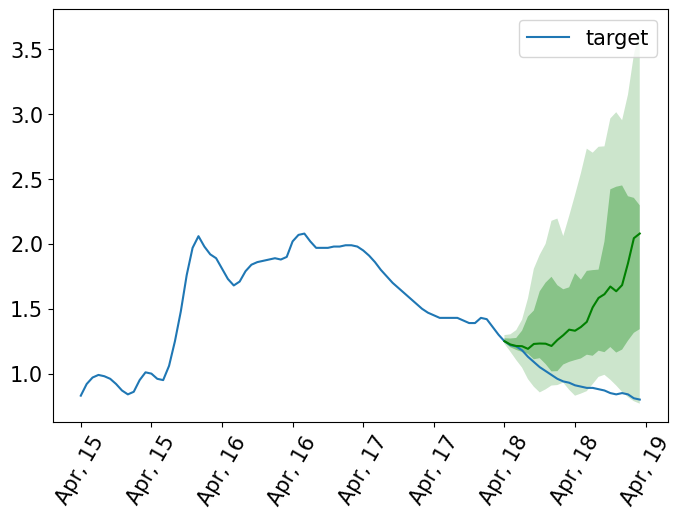

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()